In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

if os.path.isdir('C:\\Users\\KIIT\\Documents\\00-MINOR PROJECT\\minor_project-master'):
    print(os.listdir('C:\\Users\\KIIT\\Documents\\00-MINOR PROJECT\\minor_project-master'))
else:
    print("Directory does not exist.")
    
for dirname, _, filenames in os.walk('C:\\Users\\KIIT\\Documents\\00-MINOR PROJECT\\minor_project-master'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

['.ipynb_checkpoints', 'contour.jpg', 'data', 'EasyChair-Preprint-5559.pdf', 'img1.jpg', 'img10.jpg', 'img11.jpg', 'img2.jpg', 'img3.jpg', 'img4.jpg', 'img5.jpg', 'img6.jpg', 'img6.png', 'img7.jpg', 'img8.jpg', 'img9.jpg', 'img9i.jpg', 'indian_license_plate.xml', 'Minor_project_final_notebook_Final.ipynb', 'Minor_project_final_notebook_Test1.ipynb', 'owners.csv']
C:\Users\KIIT\Documents\00-MINOR PROJECT\minor_project-master\contour.jpg
C:\Users\KIIT\Documents\00-MINOR PROJECT\minor_project-master\EasyChair-Preprint-5559.pdf
C:\Users\KIIT\Documents\00-MINOR PROJECT\minor_project-master\img1.jpg
C:\Users\KIIT\Documents\00-MINOR PROJECT\minor_project-master\img10.jpg
C:\Users\KIIT\Documents\00-MINOR PROJECT\minor_project-master\img11.jpg
C:\Users\KIIT\Documents\00-MINOR PROJECT\minor_project-master\img2.jpg
C:\Users\KIIT\Documents\00-MINOR PROJECT\minor_project-master\img3.jpg
C:\Users\KIIT\Documents\00-MINOR PROJECT\minor_project-master\img4.jpg
C:\Users\KIIT\Documents\00-MINOR PROJECT\m

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [4]:
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier("C:\\Users\\KIIT\\Documents\\00-MINOR PROJECT\\minor_project-master\\indian_license_plate.xml")

In [41]:
def detect_plate(img): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-10, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    return plate_img, plate # returning the processed image.

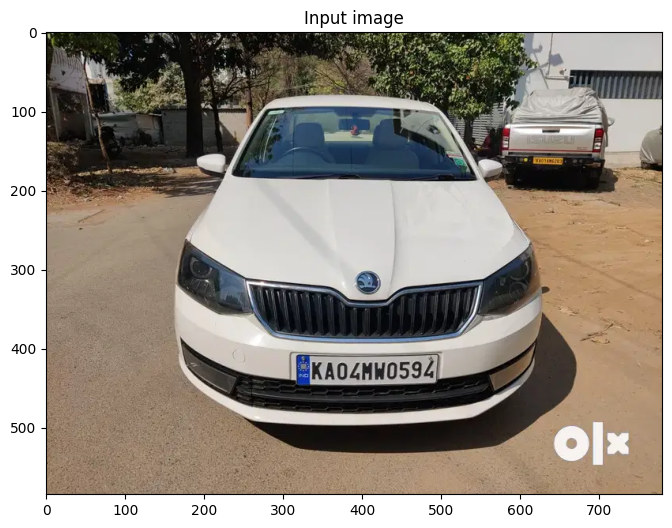

In [63]:
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    ax.set_title(title)
    plt.show()

img = cv2.imread('C:\\Users\\KIIT\\Documents\\00-MINOR PROJECT\\minor_project-master\\img11.webp')
display(img, 'Input image')


In [64]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)

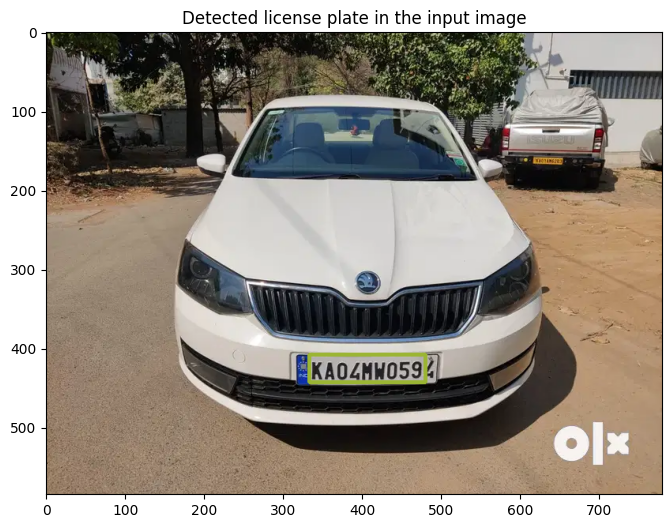

In [65]:
display(output_img, 'Detected license plate in the input image')

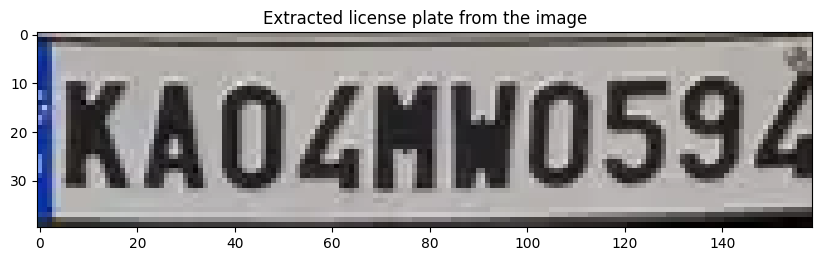

In [66]:
display(plate, 'Extracted license plate from the image')

In [67]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [68]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

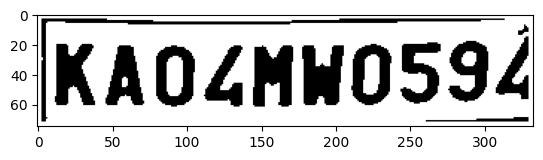

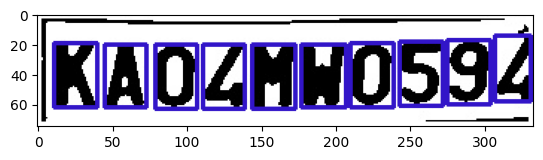

In [69]:
# Let's see the segmented characters
char = segment_characters(plate)

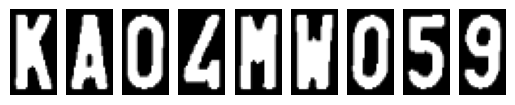

In [70]:
for i in range(9):
    plt.subplot(1, 9, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')


In [36]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = "C:\\Users\\KIIT\\Documents\\00-MINOR PROJECT\\minor_project-master\\data"
train_generator = train_datagen.flow_from_directory(
        path+"\\train",  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+"\\val",  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 867 images belonging to 36 classes.
Found 219 images belonging to 36 classes.


In [37]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [38]:
from tensorflow.keras import backend as K

K.clear_session()

model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])


In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [37]:
# class stop_training_callback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('val_custom_f1score') > 0.99):
#       self.model.stop_training = True

In [40]:
batch_size = 1
# callbacks = [stop_training_callback()]
model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples,
      validation_data = validation_generator, 
      epochs = 10)

Epoch 1/10
867/867 [==============================] - 70s 76ms/step - loss: 3.3416 - accuracy: 0.0830 - val_loss: 2.5221 - val_accuracy: 0.2785
Epoch 2/10
 90/867 [==>...........................] - ETA: 1:04 - loss: 2.5041 - accuracy: 0.3111

KeyboardInterrupt: 

In [57]:
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results(model, char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_prob = model.predict(img)[0] #predicting the class probabilities
        y_ = np.argmax(y_prob) #getting the index of the predicted class
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    return plate_number


print(show_results(model, char))

1/1 [==============================] - 0s 125ms/step
UP16AD2278


1/1 [==============================] - 0s 129ms/step


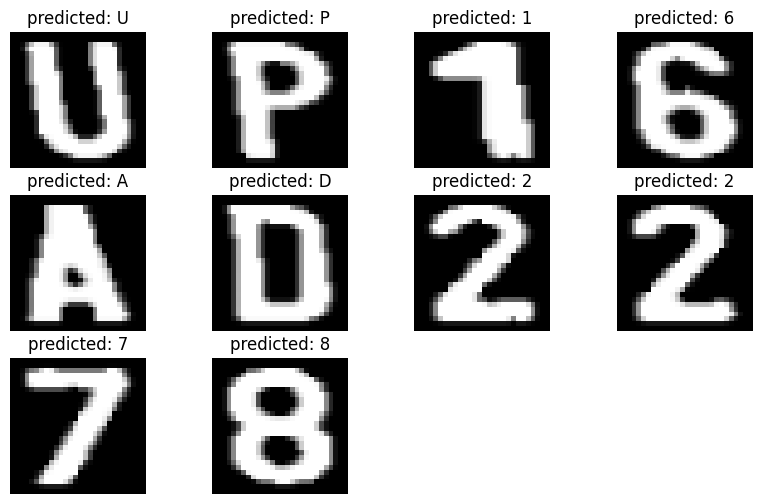

In [58]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results(model, [ch])}')
    plt.axis('off')
plt.show()

THE WHOLE WORK FLOW : 


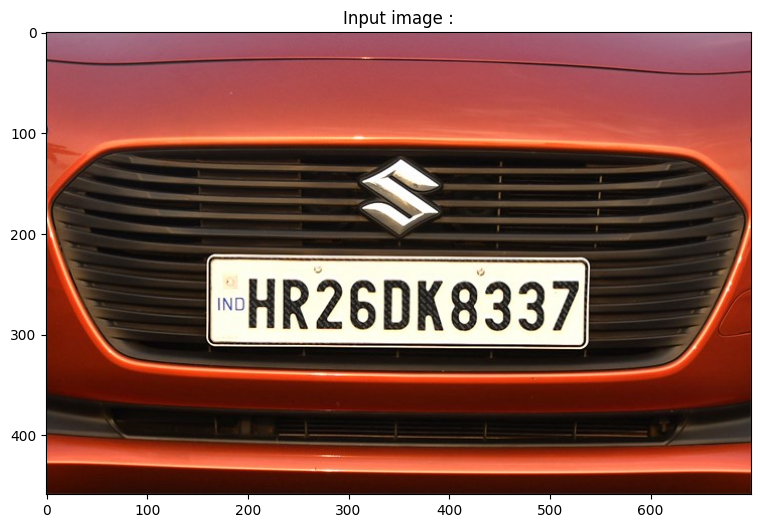

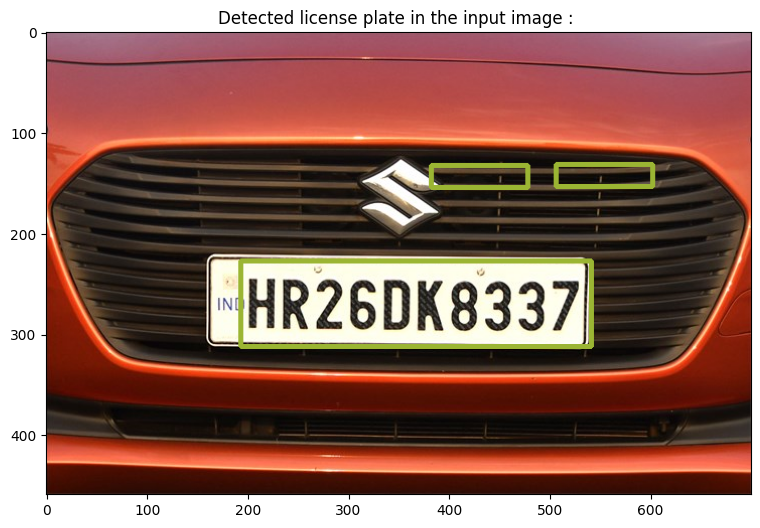

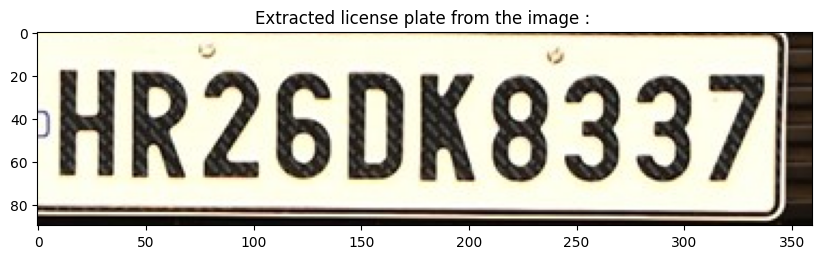

Results to find characters in the resulting images :


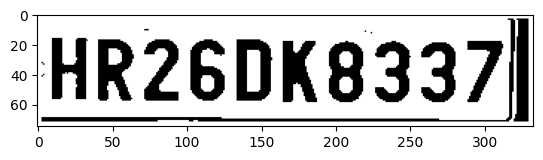

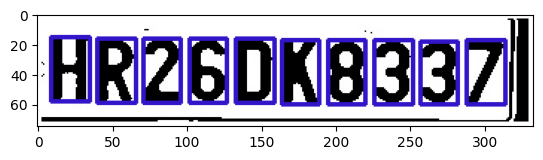

Results for the detected license plate characters :
1/1 [==============================] - 0s 35ms/step
BBBBBBBBBB
Results for Segmented characters and their predicted value : 
1/1 [==============================] - 0s 29ms/step


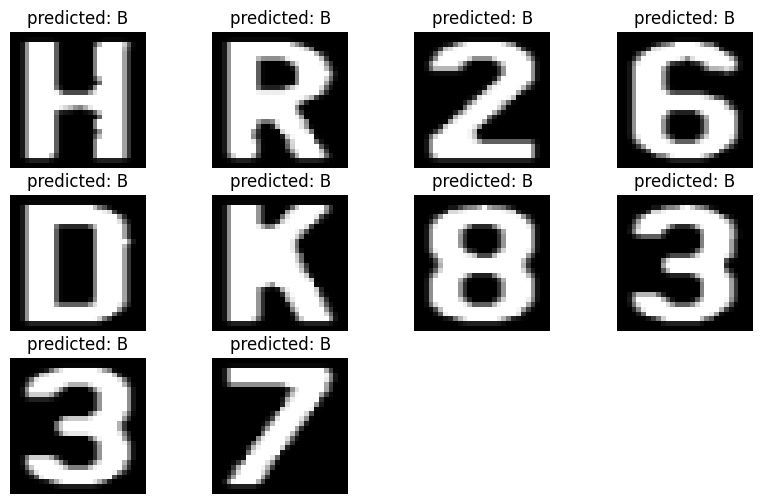

In [77]:
print("THE WHOLE WORK FLOW : ")

plate_cascade = cv2.CascadeClassifier("C:\\Users\\KIIT\\Documents\\00-MINOR PROJECT\\minor_project-master\\indian_license_plate.xml")

def detect_plate(img): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-10, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    return plate_img, plate # returning the processed image.

img = cv2.imread("C:\\Users\\KIIT\\Documents\\00-MINOR PROJECT\\minor_project-master\\img1.jpg")
display(img, 'Input image :')

output_img, plate = detect_plate(img)
display(output_img, 'Detected license plate in the input image : ')
display(plate, 'Extracted license plate from the image : ')
print("Results to find characters in the resulting images :")
char = segment_characters(plate)
print("Results for the detected license plate characters :")
print(show_results(model, char))
plt.figure(figsize=(10,6))
print("Results for Segmented characters and their predicted value : ")
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')    
    plt.title(f'predicted: {show_results(model, char)[i]}')
    plt.axis('off')
plt.show()

In [250]:
print(show_results(model, char))

1/1 [==============================] - 0s 70ms/step
KA22MA8333


In [251]:
plate_number = show_results(model, char)

1/1 [==============================] - 0s 71ms/step


In [252]:
print(plate_number)

KA22MA8333


In [1]:
import pandas as pd

In [2]:
user_db = pd.read_csv('owners.csv')

In [4]:
match = user_db[user_db['license_number'] == 'MH02VD2636']

In [6]:
if not match.empty:
    print(f"Owner Name: {match['owner_name'].values[0]}")
    print(f"License Number: {match['license_number'].values[0]}")
    print(f"Model Name: {match['Model Name'].values[0]}")
    print(f"Registration Office: {match['Registration Office'].values[0]}")
else:
    print("Car owner not found in the database.")

Owner Name: Sammer Roy
License Number: MH02VD2636
Model Name: MARUTI SUZUKI
Registration Office: Andheri RTO


In [257]:

import requests

url = "https://vehicle-rc-information.p.rapidapi.com/"
plate_number = show_results(model, char)
payload = {"VehicleNumber": plate_number}
headers = {
	"content-type": "application/json",
	"X-RapidAPI-Key": "00ed3e2ca4mshd5768034b2d1810p17ec02jsn8ac495719426",
	"X-RapidAPI-Host": "vehicle-rc-information.p.rapidapi.com"
}

response = requests.request("POST", url, json=payload, headers=headers)

print(response.text)

1/1 [==============================] - 0s 79ms/step
{"message":"You have exceeded the MONTHLY quota for Requests on your current plan, BASIC. Upgrade your plan at https:\/\/rapidapi.com\/fatehbrar92\/api\/vehicle-rc-information"}


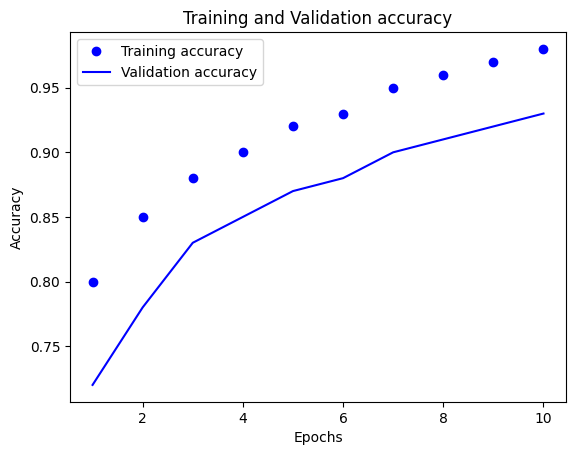

In [59]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, 11) # example data for 10 epochs
train_acc = [0.8, 0.85, 0.88, 0.9, 0.92, 0.93, 0.95, 0.96, 0.97, 0.98] # example data for training accuracy
val_acc = [0.72, 0.78, 0.83, 0.85, 0.87, 0.88, 0.9, 0.91, 0.92, 0.93] # example data for validation accuracy

plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()